# Gaussian Shells

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
rstate = np.random.default_rng(715)


In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

# 2-D Gaussian Shells

To demonstrate more of the functionality afforded by our different sampling/bounding options we will demonstrate how these various features work using a set of 2-D **Gaussian shells** with a uniform prior over $[-6, 6]$.

In [4]:
# defining constants
r = 2.  # radius
w = 0.1  # width
c1 = np.array([-3.5, 0.])  # center of shell 1
c2 = np.array([3.5, 0.])  # center of shell 2
const = math.log(1. / math.sqrt(2. * math.pi * w**2))  # normalization constant

# log-likelihood of a single shell
def logcirc(theta, c):
    d = np.sqrt(np.sum((theta - c)**2, axis=-1))  # |theta - c|
    return const - (d - r)**2 / (2. * w**2)

# log-likelihood of two shells
def loglike(theta):
    return np.logaddexp(logcirc(theta, c1), logcirc(theta, c2))

# our prior transform
def prior_transform(x):
    return 12. * x - 6.

In [5]:
# compute likelihood surface over a 2-D grid
xx, yy = np.meshgrid(np.linspace(-6., 6., 200), np.linspace(-6., 6., 200))
L = np.exp(loglike(np.dstack((xx, yy))))

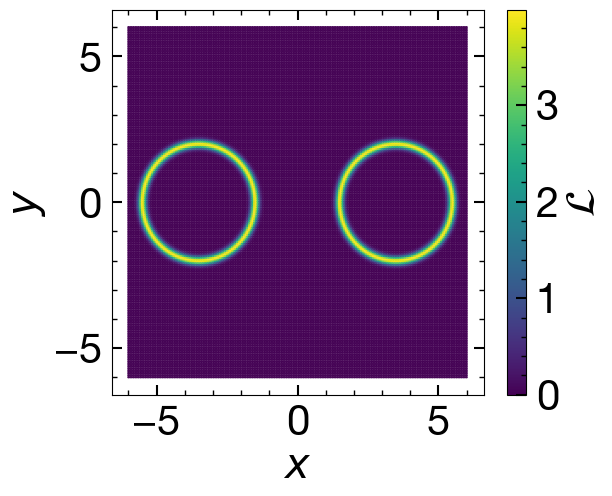

In [6]:
# plot result
fig = plt.figure(figsize=(6,5))
plt.scatter(xx, yy, c=L, s=0.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(label=r'$\mathcal{L}$');

# Default Run

Let's first run with just the default set of `dynesty` options.

In [7]:
# run with all defaults
sampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=2, rstate=rstate)
sampler.run_nested()
res = sampler.results

2820it [00:08, 101.71it/s, batch: 0 | bound: 26 | nc: 42 | ncall: 29883 | eff(%):  9.282 | loglstar:   -inf <  1.380 <    inf | logz: -1.776 +/-  0.072 | dlogz:  0.081 >  0.010]/home/skoposov/pyenv_dir/pyenv312/lib/python3.12/site-packages/dynesty/bounding.py:678: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
3064it [00:14, 15.59it/s, batch: 0 | bound: 45 | nc: 939 | ncall: 43794 | eff(%):  6.917 | loglstar:   -inf <  1.382 <    inf | logz: -1.744 +/-  0.072 | dlogz:  0.049 >  0.010]/home/skoposov/pyenv_dir/pyenv312/lib/python3.12/site-packages/dynesty/bounding.py:678: UserWarning: The enlargement factor for the ellipsoidal bounds determine

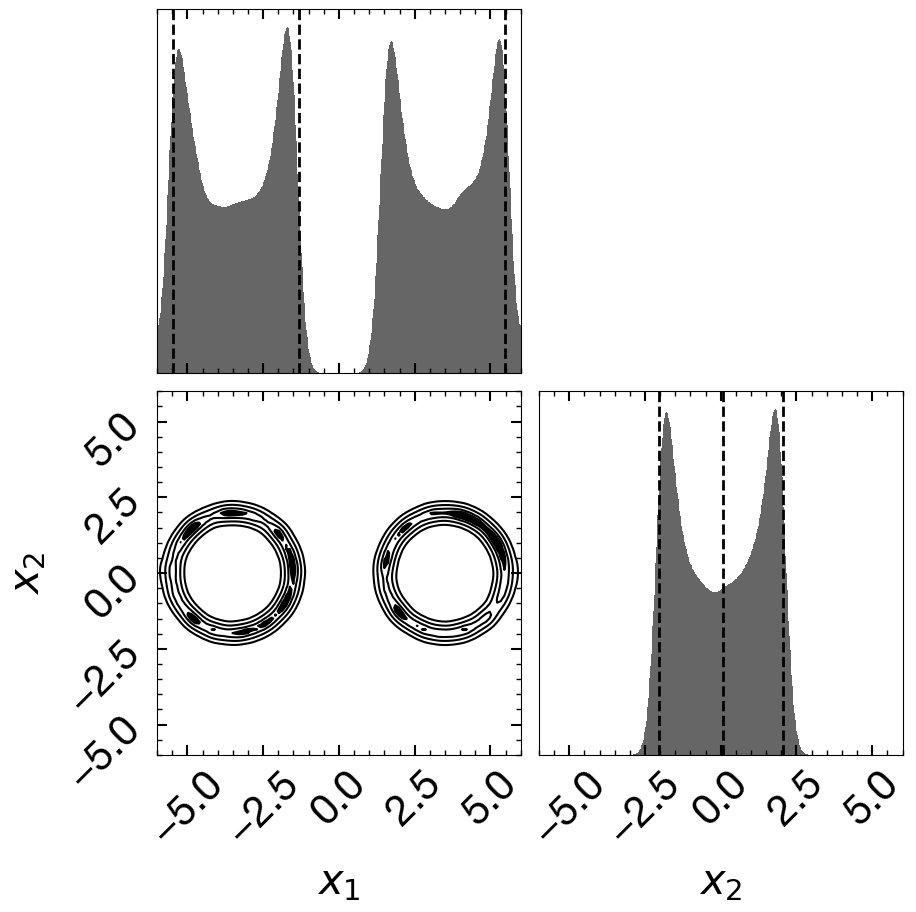

In [8]:
from dynesty import plotting as dyplot
dyplot.cornerplot(sampler.results, span=([-6, 6], [-6, 6]), fig=plt.subplots(2, 2, figsize=(10, 10)));

# Bounding Options

Let's test out the bounding options available in `dynesty` (with uniform sampling) on these 2-D shells. To illustrate their baseline effectiveness, we will also disable the initial delay before our first update.

In [9]:
# bounding methods
bounds = ['none', 'single', 'multi', 'balls', 'cubes']

# run over each method and collect our results
bounds_res = []
for b in bounds:
    sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=2,
                                    bound=b, sample='unif', nlive=500,
                                    first_update={'min_ncall': 0.,
                                                  'min_eff': 100.}, rstate=rstate)
    sys.stderr.flush()
    sys.stderr.write('{}:\n'.format(b))
    sys.stderr.flush()
    t0 = time.time()
    sampler.run_nested(dlogz=0.05)
    t1 = time.time()
    res = sampler.results
    dtime = t1 - t0
    sys.stderr.flush()
    sys.stderr.write('\ntime: {0}s\n\n'.format(dtime))
    bounds_res.append(sampler.results)

none:
3124it [00:07, 441.71it/s, +500 | bound: 348 | nc: 1 | ncall: 253624 | eff(%):  1.432 | loglstar:   -inf <  1.384 <    inf | logz: -1.836 +/-  0.072 | dlogz:  0.000 >  0.050]

time: 7.07368803024292s

single:
3099it [00:04, 713.61it/s, +500 | bound: 157 | nc: 1 | ncall: 92222 | eff(%):  3.924 | loglstar:   -inf <  1.384 <    inf | logz: -1.786 +/-  0.071 | dlogz:  0.000 >  0.050]

time: 4.3438560962677s

multi:
2795it [00:14, 50.17it/s, bound: 47 | nc: 95 | ncall: 26108 | eff(%): 10.706 | loglstar:   -inf <  1.379 <    inf | logz: -1.848 +/-  0.073 | dlogz:  0.091 >  0.050]/home/skoposov/pyenv_dir/pyenv312/lib/python3.12/site-packages/dynesty/bounding.py:678: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or r

We can see the amount of overhead associated with `'balls'` and `'cubes'` is non-trivial in this case. This mainly comes from sampling from our bouding distributions, since accepting or rejecting a point requires counting all neighbors within some radius $r$, leading to frequent nearest-neighbor searches.

Runtime aside, we see that each method runs for a similar number of iterations and give similar `logz` values (with comparable errors). They thus appear to be unbiased both with respect to each other and with respect to the analytic solution ($\ln \mathcal{Z} = -1.75$).

To get a sense of what each of our bounds looks like, we can use some of `dynesty`'s built-in plotting functionality. First, let's take a look at the case where we had no bounds (`'none'`).

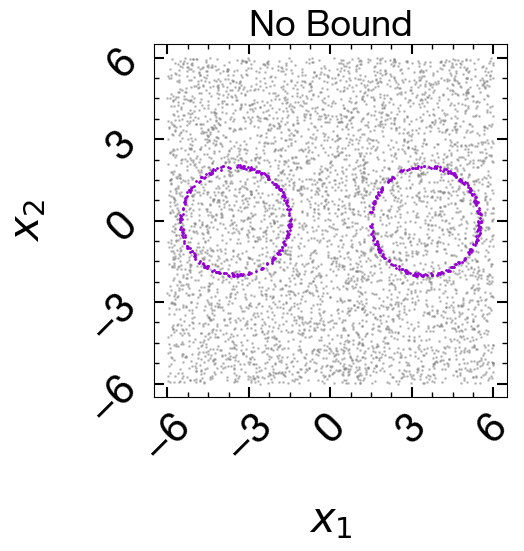

In [10]:
from dynesty import plotting as dyplot

# initialize figure
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

# plot proposals in corner format for 'none'
fg, ax = dyplot.cornerbound(bounds_res[0], it=2000, prior_transform=prior_transform,
                            show_live=True, fig=(fig, axes))
ax[0, 0].set_title('No Bound', fontsize=26)
ax[0, 0].set_xlim([-6.5, 6.5])
ax[0, 0].set_ylim([-6.5, 6.5]);

Now let's examine the single and multi-ellipsoidal cases.

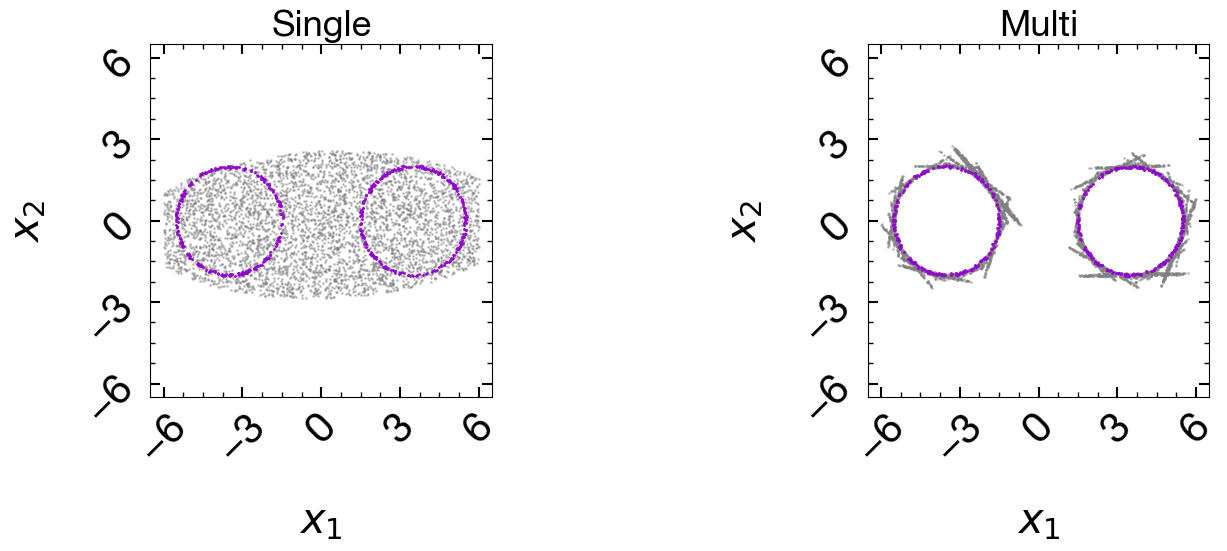

In [11]:
# initialize figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.reshape((1, 3))
[a.set_frame_on(False) for a in axes[:, 1]]
[a.set_xticks([]) for a in axes[:, 1]]
[a.set_yticks([]) for a in axes[:, 1]]

# plot proposals in corner format for 'single'
fg, ax = dyplot.cornerbound(bounds_res[1], it=2000, prior_transform=prior_transform,
                            show_live=True, fig=(fig, axes[:, 0]))
ax[0, 0].set_title('Single', fontsize=26)
ax[0, 0].set_xlim([-6.5, 6.5])
ax[0, 0].set_ylim([-6.5, 6.5])

# plot proposals in corner format for 'multi'
fg, ax = dyplot.cornerbound(bounds_res[2], it=2000, prior_transform=prior_transform,
                            show_live=True, fig=(fig, axes[:, 2]))
ax[0, 0].set_title('Multi', fontsize=26)
ax[0, 0].set_xlim([-6.5, 6.5])
ax[0, 0].set_ylim([-6.5, 6.5]);

Finally, let's take a look at our overlapping set of balls and cubes.

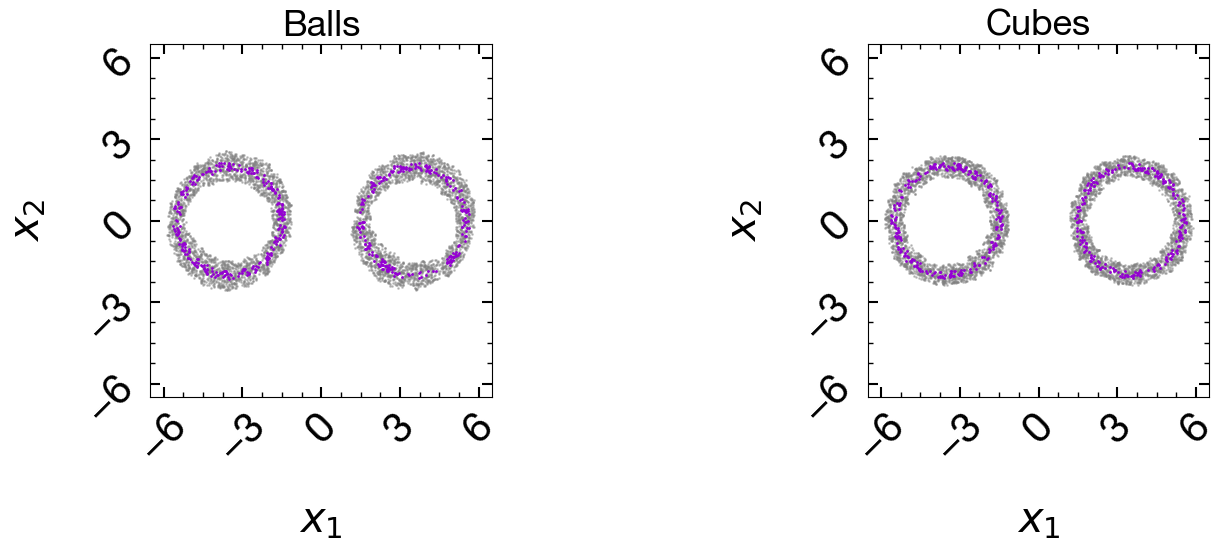

In [12]:
# initialize figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.reshape((1, 3))
[a.set_frame_on(False) for a in axes[:, 1]]
[a.set_xticks([]) for a in axes[:, 1]]
[a.set_yticks([]) for a in axes[:, 1]]

# plot proposals in corner format for 'balls'
fg, ax = dyplot.cornerbound(bounds_res[3], it=1500, prior_transform=prior_transform,
                            show_live=True, fig=(fig, axes[:, 0]))
ax[0, 0].set_title('Balls', fontsize=26)
ax[0, 0].set_xlim([-6.5, 6.5])
ax[0, 0].set_ylim([-6.5, 6.5])

# plot proposals in corner format for 'cubes'
fg, ax = dyplot.cornerbound(bounds_res[4], it=1500, prior_transform=prior_transform,
                            show_live=True, fig=(fig, axes[:, 2]))
ax[0, 0].set_title('Cubes', fontsize=26)
ax[0, 0].set_xlim([-6.5, 6.5])
ax[0, 0].set_ylim([-6.5, 6.5]);

# Bounding Objects

By default, the nested samplers in `dynesty` save all bounding distributions used throughout the course of a run, which can be accessed within the `results` dictionary. More information on these distributions can be found in `bounding.py`.

In [13]:
# the proposals associated with our 'multi' bounds
bounds_res[2].bound

Each bounding object has a host of additional functionality that the user can experiment with. For instance, the volume contained by the *union* of ellipsoids within `MultiEllipsoid` can be estimated using **Monte Carlo integration** (but otherwise are not computed by default). These volume estimates, combined with what fraction of our samples overlap with the unit cube (since our bounding distributions can exceed our prior bounds), can give us an idea of how effectively our multi-ellipsoid bounds are shrinking over time compared with the single-ellipsoid case.

In [14]:
# compute effective 'single' volumes
single_logvols = [0.]  # unit cube
for bound in bounds_res[1].bound[1:]:
    logvol = bound.logvol  # volume
    funit = bound.unitcube_overlap(rstate=rstate) # fractional overlap with unit cube
    single_logvols.append(logvol +np.log(funit))
single_logvols = np.array(single_logvols)

# compute effective 'multi' volumes
multi_logvols = [0.]  # unit cube
for bound in bounds_res[2].bound[1:]:  # skip unit cube
    logvol, funit = bound.monte_carlo_logvol(rstate=rstate, return_overlap=True)
    multi_logvols.append(logvol +np.log( funit))  # numerical estimate via Monte Carlo methods
multi_logvols = np.array(multi_logvols)

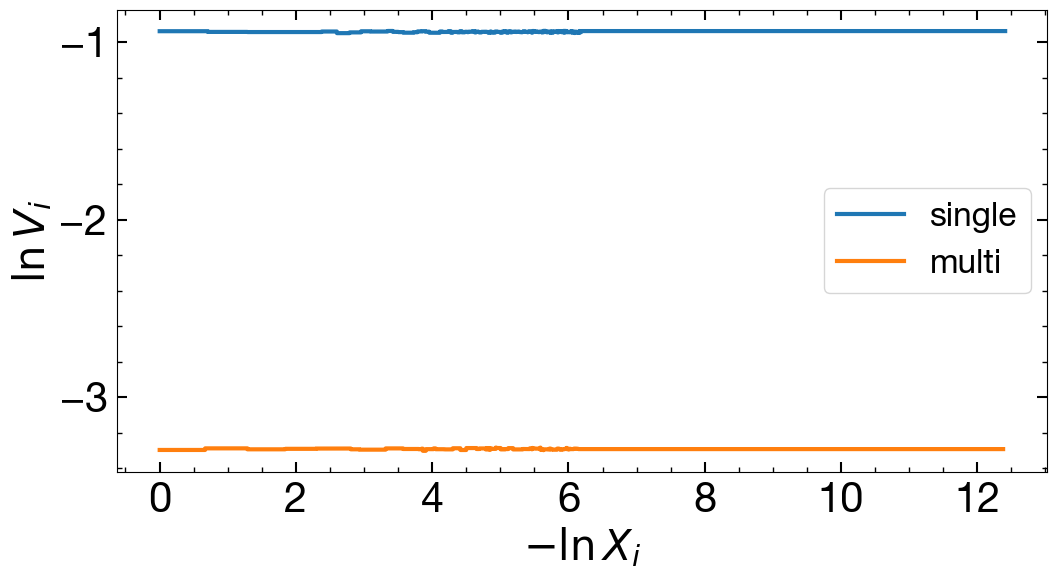

In [15]:
# plot results as a function of ln(volume)
plt.figure(figsize=(12,6))
plt.xlabel(r'$-\ln X_i$')
plt.ylabel(r'$\ln V_i$')

# 'single'
res = bounds_res[1]
x = -res.logvol  # ln(prior volume)
it = res.bound_iter  # proposal idx at given iteration
y = single_logvols[it]  # corresponding ln(bounding volume)
plt.plot(x, y, lw=3, label='single')

# 'multi'
res = bounds_res[2]
x, it = -res.logvol, res.bound_iter
y = multi_logvols[it]
plt.plot(x, y, lw=3, label='multi')
plt.legend(loc='best', fontsize=24);

We see that in the beginning, only a single ellipsoid is used. After some bounding updates have been made, there is enough of an incentive to split the proposal into several ellipsoids. Although the initial ellipsoid decompositions can be somewhat unstable (i.e. bootstrapping can give relatively large volume expansion factors), over time this process leads to a significant decrease in effective overall volume.

# Sampling Options

Let's test out the sampling options available in `dynesty` (with `'multi'` bounding) on our 2-D shells defined above.

In [17]:
# bounding methods
sampling = ['unif', 'rwalk', 'slice', 'rslice']

# run over each method and collect our results
sampling_res = []
for s in sampling:
    sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=2,
                                    bound='multi', sample=s, nlive=1000,
                                   rstate=rstate)
    sys.stderr.flush()
    sys.stderr.write('{}:\n'.format(s))
    sys.stderr.flush()
    t0 = time.time()
    sampler.run_nested(dlogz=0.05)
    t1 = time.time()
    res = sampler.results
    dtime = t1 - t0
    sys.stderr.flush()
    sys.stderr.write('\ntime: {0}s\n\n'.format(dtime))
    sampling_res.append(sampler.results)

unif:
6126it [00:16, 381.81it/s, +1000 | bound: 22 | nc: 1 | ncall: 59835 | eff(%): 12.112 | loglstar:   -inf <  1.384 <    inf | logz: -1.718 +/-  0.050 | dlogz:  0.000 >  0.050]

time: 16.04570746421814s

rwalk:
6101it [00:06, 933.54it/s, +1000 | bound: 14 | nc: 1 | ncall: 92680 | eff(%):  7.745 | loglstar:   -inf <  1.384 <    inf | logz: -1.693 +/-  0.049 | dlogz:  0.000 >  0.050]

time: 6.536514520645142s

slice:
4983it [00:05, 308.38it/s, bound: 12 | nc: 25 | ncall: 95172 | eff(%):  5.236 | loglstar:   -inf <  1.363 <    inf | logz: -1.903 +/-  0.052 | dlogz:  0.169 >  0.050]/home/skoposov/pyenv_dir/pyenv312/lib/python3.12/site-packages/dynesty/sampling.py:1143: UserWarning: The slice sample interval was expanded more than 1000 times
  warnings.warn('The slice sample interval was expanded more '
/home/skoposov/pyenv_dir/pyenv312/lib/python3.12/site-packages/dynesty/sampling.py:694: UserWarning: Enabling doubling strategy of slice sampling from Neal(2003)
  warnings.warn('Enabling

As expected, uniform sampling in 2-D is substantially more efficient than other more complex alternatives. Regardless of runtime, however, we see that each method runs for a similar number of iterations and gives similar `logz` values (with comparable errors). They thus appear to be unbiased both with respect to each other and with respect to the analytic solution ($\ln\mathcal{Z} = −1.75$).

# Bootstrapping

One of the largest overheads associated with nested sampling is the time needed to propose new bounding distributions. To avoid bounding distributions that fail to properly encompass the remaining likelihood, `dynesty` automatically expands the volume of all bounding distributions by an enlargement factor (`enlarge`). By default, this factor is set to a constant value of `1.25`. However, it can also be determined in real time using **bootstrapping** (over the set of live points) following the scheme outlined in [Buchner (2014)](https://arxiv.org/abs/1407.5459).

Bootstrapping these expansion factors can help to ensure accurate evidence estimation when the proposals rely heavily on the *size* of an object rather than the overall *shape*, such as when proposing new points uniformly within their boundaries. In theory, it also helps to prevent mode "death": if occasionally a secondary mode disappears when bootstrapping, the existing bounds would be expanded to theoretically encompass it. In practice, however, most modes are widely separated, leading enormous expansion factors whenever any possible instance of mode death may occur. 

Bootstrapping thus imposes a *de facto* floor on the number of acceptable live points to avoid mode death for any given problem, which can often be quite large for many problems. **While these numbers are often justified**, they can drastically reduce the raw sampling efficiency until such a target threshold of live points is reached.

We showcase this behavior below by illustrating the performance of our `NestedSampler` on several N-D Gaussian shells with and without bootstrapping.

In [18]:
# setup for running tests over gaussian shells in arbitrary dimensions
def run(ndim, bootstrap, bound, method, nlive):
    """Convenience function for running in any dimension."""

    c1 = np.zeros(ndim)
    c1[0] = -3.5
    c2 = np.zeros(ndim)
    c2[0] = 3.5
    f = lambda theta: np.logaddexp(logcirc(theta, c1), logcirc(theta, c2))
    sampler = dynesty.NestedSampler(f, prior_transform, ndim,
                                    bound=bound, sample=method, nlive=nlive, 
                                    bootstrap=bootstrap, 
                                    first_update={'min_ncall': 0.,
                                                  'min_eff': 100.},
                                   rstate=rstate)
    sampler.run_nested(dlogz=0.5)
    
    return sampler.results

# analytic ln(evidence) values
ndims = [2, 5, 10]
analytic_logz = {2: -1.75,
                 5: -5.67,
                 10: -14.59}

In [19]:
# results with bootstrapping
results = []
times = []
for ndim in ndims:
    t0 = time.time()
    sys.stderr.flush()
    sys.stderr.write('{} dimensions:\n'.format(ndim))
    sys.stderr.flush()
    res = run(ndim, 20, 'multi', 'unif', 2000)
    sys.stderr.flush()
    curdt = time.time() - t0
    times.append(curdt)
    sys.stderr.write('\ntime: {0}s\n\n'.format(curdt))
    results.append(res)

2 dimensions:
8104it [00:35, 229.75it/s, +2000 | bound: 9 | nc: 1 | ncall: 21342 | eff(%): 52.239 | loglstar:   -inf <  1.384 <    inf | logz: -1.750 +/-  0.026 | dlogz:  0.000 >  0.500]

time: 35.32247233390808s

5 dimensions:
15823it [00:40, 393.34it/s, +2000 | bound: 19 | nc: 1 | ncall: 40950 | eff(%): 45.759 | loglstar:   -inf <  1.384 <    inf | logz: -5.610 +/-  0.051 | dlogz:  0.000 >  0.500]

time: 40.28961396217346s

10 dimensions:
33547it [01:08, 490.90it/s, +2000 | bound: 49 | nc: 1 | ncall: 101463 | eff(%): 35.739 | loglstar:   -inf <  1.384 <    inf | logz: -14.471 +/-  0.084 | dlogz:  0.000 >  0.500]

time: 68.4429702758789s



In [20]:
# results without bootstrapping
results2 = []
times2 = []
for ndim in ndims:
    t0 = time.time()
    sys.stderr.flush()
    sys.stderr.write('{} dimensions:\n'.format(ndim))
    sys.stderr.flush()
    res = run(ndim, 0, 'multi', 'unif', 2000)
    sys.stderr.flush()
    curdt = time.time() - t0
    times2.append(curdt)
    sys.stderr.write('\ntime: {0}s\n\n'.format(curdt))
    results2.append(res)

2 dimensions:
8019it [00:05, 1405.84it/s, +2000 | bound: 7 | nc: 1 | ncall: 17730 | eff(%): 63.694 | loglstar:   -inf <  1.384 <    inf | logz: -1.706 +/-  0.025 | dlogz:  0.000 >  0.500]

time: 5.752566814422607s

5 dimensions:
16009it [00:10, 1586.27it/s, +2000 | bound: 17 | nc: 1 | ncall: 37647 | eff(%): 50.520 | loglstar:   -inf <  1.384 <    inf | logz: -5.701 +/-  0.051 | dlogz:  0.000 >  0.500]

time: 10.154923677444458s

10 dimensions:
33621it [00:19, 1691.47it/s, +2000 | bound: 39 | nc: 1 | ncall: 82075 | eff(%): 44.485 | loglstar:   -inf <  1.384 <    inf | logz: -14.509 +/-  0.084 | dlogz:  0.000 >  0.500]

time: 19.981729984283447s



In [21]:
print('With bootstrapping:')
print("D  analytic    logz  logzerr   nlike  eff(%)   time")
for ndim, curt, res in zip(ndims, times, results):
    print("{:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:6d}   {:5.2f}  {:6.2f}"
          .format(ndim, analytic_logz[ndim], res.logz[-1], res.logzerr[-1],
                  sum(res.ncall), res.eff, curt))
print('\n')
print('Without bootstrapping:')
print("D  analytic    logz  logzerr   nlike  eff(%)   time")
for ndim, curt, res in zip(ndims, times2, results2):
    print("{:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:6d}   {:5.2f}  {:6.2f}"
          .format(ndim, analytic_logz[ndim], res.logz[-1], res.logzerr[-1],
                  sum(res.ncall), res.eff, curt))

With bootstrapping:
D  analytic    logz  logzerr   nlike  eff(%)   time
 2    -1.75   -1.75     0.07   19342   52.24   35.32
 5    -5.67   -5.61     0.11   38950   45.76   40.29
10   -14.59  -14.47     0.17   99463   35.74   68.44


Without bootstrapping:
D  analytic    logz  logzerr   nlike  eff(%)   time
 2    -1.75   -1.71     0.07   15730   63.69    5.75
 5    -5.67   -5.70     0.11   35647   50.52   10.15
10   -14.59  -14.51     0.17   80075   44.48   19.98


While our results are comparable between both cases, in higher dimensions multi-ellipsoid bounding distributions can sometimes be over-constrained, leading to biased results. Other sampling methods mitigate this problem by sampling *conditioned* on the ellipsoid axes, and so only depends on ellipsoid shapes, not sizes. `'rslice'` is demonstrated below.

In [22]:
# adding on slice sampling
results3 = []
times3 = []
for ndim in ndims:
    t0 = time.time()
    sys.stderr.flush()
    sys.stderr.write('{} dimensions:\n'.format(ndim))
    sys.stderr.flush()
    res = run(ndim, 0, 'multi', 'rslice', 2000)
    sys.stderr.flush()
    curdt = time.time() - t0
    times3.append(curdt)
    sys.stderr.write('\ntime: {0}s\n\n'.format(curdt))
    results3.append(res)

2 dimensions:
8101it [00:15, 520.83it/s, +2000 | bound: 24 | nc: 1 | ncall: 233401 | eff(%):  4.365 | loglstar:   -inf <  1.384 <    inf | logz: -1.749 +/-  0.026 | dlogz:  0.000 >  0.500]

time: 15.603750705718994s

5 dimensions:
15805it [00:28, 546.54it/s, +2000 | bound: 42 | nc: 1 | ncall: 674218 | eff(%):  2.649 | loglstar:   -inf <  1.384 <    inf | logz: -5.600 +/-  0.051 | dlogz:  0.000 >  0.500]

time: 28.980507850646973s

10 dimensions:
33639it [01:19, 422.97it/s, +2000 | bound: 89 | nc: 1 | ncall: 2317742 | eff(%):  1.539 | loglstar:   -inf <  1.384 <    inf | logz: -14.518 +/-  0.084 | dlogz:  0.000 >  0.500]

time: 79.64467358589172s



In [23]:
print('Random Slice sampling:')
print("D  analytic    logz  logzerr    nlike   eff(%)   time")
for ndim, curt, res in zip([2, 5, 10, 20], times3, results3):
    print("{:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:8d}   {:5.2f}  {:6.2f}"
          .format(ndim, analytic_logz[ndim], res.logz[-1], res.logzerr[-1],
                  sum(res.ncall), res.eff, curt))

Random Slice sampling:
D  analytic    logz  logzerr    nlike   eff(%)   time
 2    -1.75   -1.75     0.07    231401    4.37   15.60
 5    -5.67   -5.60     0.11    672218    2.65   28.98
10   -14.59  -14.52     0.17   2315742    1.54   79.64
